In [196]:
from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
import sys
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
from pprint import pprint
from cloudmesh.common.dotdict import dotdict
import numpy as np

In [197]:
list_of_dirs = [
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70)]


In [198]:
files = []
for directory, epoch in list_of_dirs:
    gpulog = Path(directory) / "gpu0.log"
    eventlog = glob.glob(f"{directory}/*.err")[0]
    files.append(dotdict(
        {
            "epoch" : epoch,
            "eventlog": eventlog,
            "gpulog": gpulog
        })
    )

pprint (files)

[{'epoch': 2,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\dje5dj-45737981.err',
  'gpulog': WindowsPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log')},
 {'epoch': 30,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30\\dje5dj-45737982.err',
  'gpulog': WindowsPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log')},
 {'epoch': 70,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70\\dje5dj-45737983.err',
  'gpulog': WindowsPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log')}]


In [199]:
def convert_column_to_seconds(df, col):
    # df[[name]] = df[[name]].astype('datetime64[us]')
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # df[[name]] = pd.to_datetime(df[[name]], errors='coerce')
    start_t = df[col].iloc[0]
    print (start_t, type(start_t))
    for index, row in df.iterrows():

        delta = df.loc[index, col] - start_t
        df.loc[index, col] = delta.total_seconds()
    # df[name_of_seconds_column] = df[name] - start_t
    # df[[name]] = df[[name]].astype(int)/1000000000
    return df

def fix_date_format(df, col):
    # if We have T in it, we do not need to fix
    for i, row in df.iterrows():
        value = df.loc[i,col]
        if "T" not in value:
            new_date = df.loc[i,col].replace(":", " ", 1)
            df.loc[i,col] = new_date
    df[col] = pd.to_datetime(df[col])
    return df

In [200]:
def read_energy(filename=None):
    location = Shell.map_filename(filename).path
    # 1: means removing hashes
    content = readfile(location).splitlines()[1:]
    # removing #
    content[0] = content[0][2:]
    # print(content[0:10])
    content = "\n".join(content)
    content = content.replace(', ', ',')
    df = pd.read_csv(io.StringIO(content),sep=',')

    df = fix_date_format(df, "time")
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    return df


In [201]:
def read_eventlog(filename):
    location = Shell.map_filename(filename).path
    content = readfile(location, encoding='utf-8')
    content = content.replace(', ', ',').splitlines()

    # headline = '# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version'
    headline = Shell.cm_grep(content, '# csv,timer')[0]
    csv_lines = Shell.cm_grep(content, '# csv')
    csv_lines = Shell.cm_grep(csv_lines, 'Linux')
    csv_lines.insert(0, headline)
    # print("\n".join(csv_lines))
    content = "\n".join(csv_lines)
    df = pd.read_csv(io.StringIO(content),sep=',')
    df = df.rename(columns={'time':'dt'})
    df = df.rename(columns={'start':'time'})
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    df = df.drop(columns=['# csv', 'status', 'sum', 'uname.node', 'user', 'uname.system', 'platform.version', 'msg'])
    t = df.pop("time")
    df.insert(0, "time", t)
    return df

In [202]:
def export_figure(x='Time/s', y='Energy/W', filename=None):
   plt.xlabel(x)
   plt.ylabel(y)
   base = os.path.dirname(filename.replace('_', '-').lower())
   png = base + ".png"
   pdf = base + ".pdf"
   plt.savefig(png, bbox_inches='tight', dpi=600)
   plt.savefig(pdf, bbox_inches='tight')

In [203]:
def plot_events_and_energy(energylog, eventlog, epoch):
    energylog.rename(columns = {'0 power_draw W': epoch}, inplace=True)
    ax = sns.lineplot(x="time", y=epoch, data=energylog)

    shadow_x = [0]
    shadow_y = [0]

    last_time = energylog.iloc[-1]["time"]

    poi = {
        'INIT': "Initialize", # ok
        #'TFTdfTotalSpec event_num:0',
        #'data head setup',
        'RunTFTCustomVersion A': "Training", # ok

        #'RunTFTCustomVersion Train Loss Val Loss event_num:0',
        #'RunTFTCustomVersion bestfit Epoch:0',
        #'RunTFTCustomVersion bestfit Network attn layer attention summary timer_num:0',
        'RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0': "Bestfit Prediction", # ok

        'RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0': "Visualize",# ok

        #'RunTFTCustomVersion bestfit finalize',
        # 'DLprediction Iteration',

        'result': "Final plots",

        # 'DLResults_Graphs timer_num:0',
        # 'RunTFTCustomVersion bestfit finalize VisualizeTFT event_num:0'
        '': "Completed"
    }

    for i, row in eventlog.iterrows():
       label = row['timer']

       if label in poi.keys():
          # print(row['timer'], row['start'])
          x = row['time']
          y = 180
          print(x, type(x), y, type(y), label, type(label))
          display_label = poi[label]
          print(display_label)
          ax.text(x, y, display_label, rotation=45)
          ax.plot(x, y)
          shadow_x.append(x)
          shadow_y.append(y)

    shadow_x.append(last_time)
    shadow_y.append(0)

    print (shadow_x)
    print (shadow_y)
    color = ["yellow","red","green","magenta","black","blue"]

    n = len(shadow_x)
    for i in range(0,n-1):
        x0 = shadow_x[i]
        x1 = shadow_x[i+1]
        plt.fill_betweenx(range(180), x0, x1, color=color[i], alpha=.1)
    # # export_figure('Time', 'Energy', filename)
    # return ax
    #sns.lineplot(x="time", y=epoch, data=energylog)

Generate output for Epoch 2


,time,timer,dt,tag
0,10.435667,total,None,TIMER1
1,10.435667,total,9876.208,TIMER2
2,25.435667,INIT,2.261,TIMER2
3,28.435667,EVAL,409.961,TIMER2
4,28.435667,PLOTS,385.099,TIMER2
...,...,...,...,...
224,9883.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
225,9883.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
226,9884.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
227,9884.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,30,64.53
1,2.381160,0,0,0,0,0,30,64.53
2,4.747577,0,0,0,0,0,30,64.53
3,7.106233,0,0,0,0,0,30,64.53
4,9.457596,0,0,0,0,0,30,64.46
...,...,...,...,...,...,...,...,...
4515,9888.009324,0,0,0,0,0,32,71.79
4516,9890.157161,0,0,0,0,0,32,71.79
4517,9892.331272,0,0,0,0,0,32,71.45
4518,9894.482647,0,0,0,0,0,32,71.79


25.43566700000156 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1665.4356670000016 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
2936.4356670000016 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
5582.435667000002 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
9632.435667000002 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.43566700000156, 1665.4356670000016, 2936.4356670000016, 5582.435667000002, 9632.435667000002, 9896.630569]
[0, 180, 180, 180, 180, 180, 0]


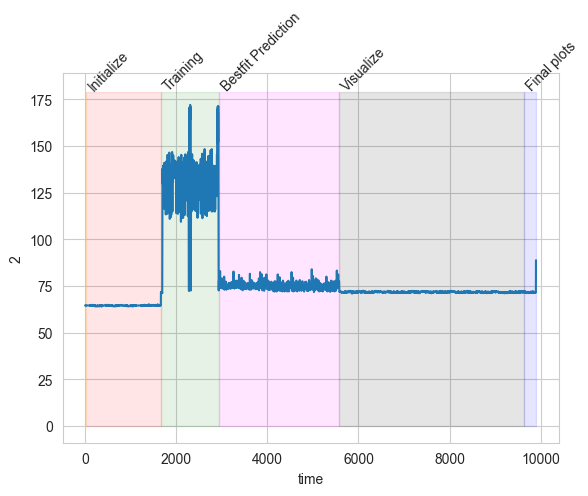

Generate output for Epoch 30


,time,timer,dt,tag
0,10.461425,total,None,TIMER1
1,10.461425,total,26757.542,TIMER2
2,25.461425,INIT,2.095,TIMER2
3,28.461425,EVAL,413.412,TIMER2
4,28.461425,PLOTS,388.651,TIMER2
...,...,...,...,...
420,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
421,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
422,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
423,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,28,62.86
1,2.172422,0,0,0,0,0,28,62.86
2,4.195892,0,0,0,0,0,28,62.86
3,6.382399,0,0,0,0,0,28,62.86
4,8.574598,0,0,0,0,0,28,62.86
...,...,...,...,...,...,...,...,...
12312,26770.241591,0,0,0,0,0,30,70.40
12313,26772.426120,0,0,0,0,0,30,70.40
12314,26774.602164,0,0,0,0,0,30,70.68
12315,26776.784935,0,0,0,0,0,30,70.68


25.461425000001327 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1686.4614250000013 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
19730.461425 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
22337.461425 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
26513.461425 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.461425000001327, 1686.4614250000013, 19730.461425, 22337.461425, 26513.461425, 26778.975483]
[0, 180, 180, 180, 180, 180, 0]


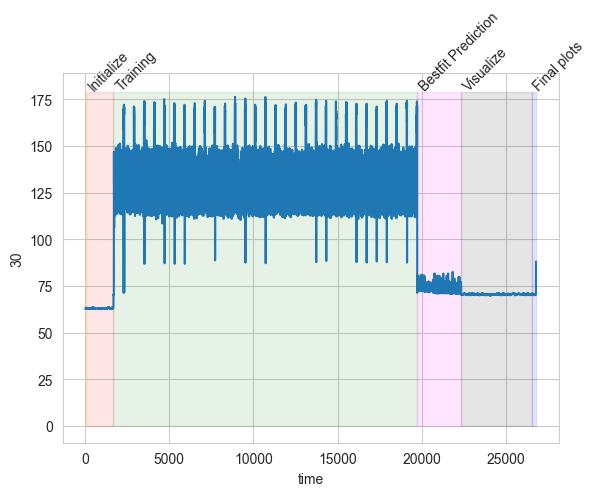

Generate output for Epoch 70


,time,timer,dt,tag
0,10.432375,total,None,TIMER1
1,10.432375,total,50441.073,TIMER2
2,25.432375,INIT,2.579,TIMER2
3,28.432375,EVAL,408.511,TIMER2
4,28.432375,PLOTS,383.499,TIMER2
...,...,...,...,...
700,50448.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
701,50448.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
702,50449.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
703,50449.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,29,61.81
1,2.377373,0,0,0,0,0,29,61.81
2,4.745279,0,0,0,0,0,29,61.81
3,7.102939,0,0,0,0,0,29,61.81
4,9.455125,0,0,0,0,0,29,61.81
...,...,...,...,...,...,...,...,...
25104,50456.757102,0,0,0,0,0,31,68.51
25105,50458.411075,0,0,0,0,0,31,68.51
25106,50460.048054,0,0,0,0,0,31,68.51
25107,50461.685282,0,0,0,0,0,32,87.30


25.43237500000032 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1691.4323750000003 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
43460.432375 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
45980.432375 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
50199.432375000004 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.43237500000032, 1691.4323750000003, 43460.432375, 45980.432375, 50199.432375000004, 50463.553789]
[0, 180, 180, 180, 180, 180, 0]


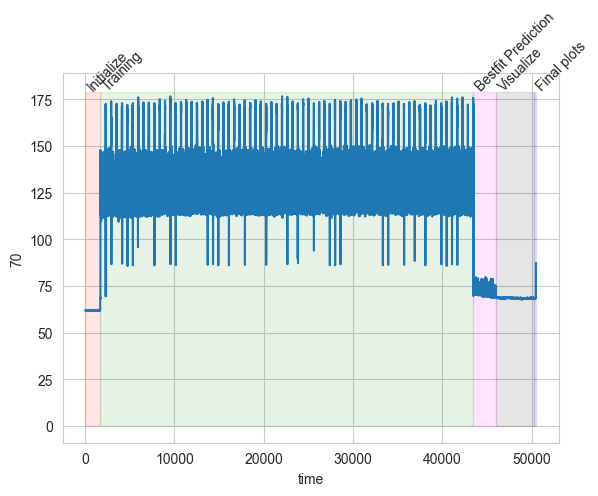

In [204]:
list_of_filenames = [('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log', 30),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log', 70)]

for entry  in files:
    print (f"Generate output for Epoch {entry.epoch}")
    energylog = read_energy(entry.gpulog)
    eventlog = read_eventlog(entry.eventlog)

    t0_energy = energylog.time.iloc[0]
    t0_events = eventlog.time.iloc[0]

    t0 = min(t0_events, t0_energy)

    energylog["time"] = energylog["time"] - t0
    eventlog["time"] = eventlog["time"] - t0

    eventlog["time"] = eventlog["time"] / np.timedelta64(1, 's') - 5 * 60 * 60
    energylog["time"] = energylog["time"] / np.timedelta64(1, 's')

    display(eventlog)

    display(energylog)

    plot_events_and_energy(energylog, eventlog, entry.epoch)
    image_file = Shell.map_filename(f'./data/shaded-energy-{entry.epoch}-epochs.png').path
    plt.savefig(image_file, bbox_inches='tight')
    image_file = Shell.map_filename(f'./data/shaded-energy-{entry.epoch}-epochs.pdf').path
    plt.savefig(image_file, bbox_inches='tight')
    plt.show()
